# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import *
from pyspark.sql.functions import sum as Fsum

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, Imputer, VectorAssembler,MinMaxScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator 
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify project').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = 'mini_sparkify_event_data.json'
spark_data = spark.read.json(path)   
spark_data.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
spark_data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
spark_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
print("Number of records in the dataset:", spark_data.count())
spark_data.describe('sessionId').show()
spark_data.describe('userId').show()
spark_data.describe('artist').show()

Number of records in the dataset: 286500
+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



It looks like there are no missing data for UserID and SessionID but we can see UserID with blank values. We will drop those values from the new spark dataset

In [8]:
#Drop null values in the userID and sessionID column 
spark_data_valid = spark_data.dropna(how='any',subset = ['userID','sessionID'])

#rows with UserID is blank
spark_data_invalid = spark_data_valid.filter(spark_data_valid['userID']=='')

#Filter out rows with UserID is blank
spark_data_valid = spark_data_valid.filter(spark_data_valid['userID']!='')

In [9]:
spark_data_invalid.take(5)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=100, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355745000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=101, lastName=None, length=None, level='free', location=None, method='GET', page='Help', registration=None, sessionId=8, song=None, status=200, ts=1538355807000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=102, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355841000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=103, lastName=None, length=None, level='free', location=None, method='PUT', page='Login', registration=None, s

In [10]:
print('# of Records after removing blank userID:', spark_data_valid.count())
print('# of Records with blank userID:', spark_data.count()-spark_data_valid.count())

# of Records after removing blank userID: 278154
# of Records with blank userID: 8346


In [11]:
# List of page values
spark_data_valid.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [12]:
# number of users by userAgent (dedup userId)
spark_data_valid.select(['userId','userAgent']).dropDuplicates().groupBy('userAgent').count().sort(desc('count')).show(100)

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Win...|   24|
|Mozilla/5.0 (Wind...|   18|
|"Mozilla/5.0 (Mac...|   16|
|"Mozilla/5.0 (Mac...|   12|
|"Mozilla/5.0 (Mac...|   12|
|"Mozilla/5.0 (Mac...|   10|
|"Mozilla/5.0 (Win...|   10|
|Mozilla/5.0 (Maci...|    9|
|"Mozilla/5.0 (iPh...|    8|
|"Mozilla/5.0 (Win...|    7|
|"Mozilla/5.0 (Mac...|    7|
|Mozilla/5.0 (Wind...|    7|
|"Mozilla/5.0 (Win...|    5|
|Mozilla/5.0 (Wind...|    4|
|"Mozilla/5.0 (Win...|    4|
|"Mozilla/5.0 (Win...|    4|
|"Mozilla/5.0 (X11...|    4|
|"Mozilla/5.0 (Win...|    4|
|Mozilla/5.0 (X11;...|    4|
|"Mozilla/5.0 (iPh...|    4|
|Mozilla/5.0 (Wind...|    3|
|Mozilla/5.0 (comp...|    3|
|"Mozilla/5.0 (Win...|    3|
|"Mozilla/5.0 (Mac...|    2|
|"Mozilla/5.0 (Mac...|    2|
|"Mozilla/5.0 (Mac...|    2|
|Mozilla/5.0 (Maci...|    2|
|"Mozilla/5.0 (Win...|    2|
|"Mozilla/5.0 (Win...|    2|
|Mozilla/5.0 (Wind...|    2|
|"Mozilla/5.0 (iPa...|    2|
|"Mozilla/5.0 

In [13]:
#can 1 user has multiple agents? Maybe Not :)"
spark_data_valid.select(['userId','userAgent']).dropDuplicates().groupBy('userId').count().sort(desc('count')).show(20)

+------+-----+
|userId|count|
+------+-----+
|100010|    1|
|200002|    1|
|   125|    1|
|     7|    1|
|    51|    1|
|   124|    1|
|    54|    1|
|    15|    1|
|   155|    1|
|100014|    1|
|   154|    1|
|   132|    1|
|   101|    1|
|    11|    1|
|300017|    1|
|   138|    1|
|100021|    1|
|    69|    1|
|    29|    1|
|   112|    1|
+------+-----+
only showing top 20 rows



In [14]:
# number of unique users
spark_data_valid.select(['userId']).dropDuplicates().count()

225

In [15]:
# number of users by Gender (dedup userId)
spark_data_valid.select(['userId','gender']).dropDuplicates().groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [16]:
# number of songs played by the most played artists
artist_chart = spark_data_valid.dropna(how='any',subset=['artist'])\
.groupBy('artist').count().sort(desc('count')).show(10)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
+--------------------+-----+
only showing top 10 rows



In [17]:
# how many distinct sessions per user
spark_data_valid.groupBy('userID')\
    .agg(countDistinct("sessionId"))\
    .withColumnRenamed("count(DISTINCT sessionId)", "sessionIdCount") \
    .sort(desc("sessionIdCount")).show()

+------+--------------+
|userID|sessionIdCount|
+------+--------------+
|    39|           107|
|    92|            86|
|200023|            76|
|300011|            76|
|   140|            71|
|300017|            63|
|300021|            58|
|    42|            47|
|    85|            41|
|    35|            38|
|    54|            37|
|200020|            36|
|   100|            35|
|    29|            34|
|300015|            33|
|    95|            33|
|    13|            33|
|    30|            32|
|     9|            31|
|   126|            30|
+------+--------------+
only showing top 20 rows



#### How many songs users listen to on average between visiting our home page?

In [18]:
# SOLUTION USING SPARK DATAFRAME

flag_home_func = udf(lambda x: 1 if x == 'Home' else 0, IntegerType())

#Create User Window
user_window = Window\
    .partitionBy('userId')\
    .orderBy('ts')\
    .rangeBetween(Window.unboundedPreceding,0)

# create 'homeSession' column to flag home event and 'songCount' to flag song played during home events
cusum = spark_data_valid.filter((spark_data_valid.page=='Home')| (spark_data_valid.page=='NextSong')) \
    .select(['userID','page','ts'])\
    .withColumn('homeSession',flag_home_func('page'))\
    .withColumn('songCount',Fsum('homeSession').over(user_window))

#cusum.filter((cusum.userID == 126)).show()

#calculate the average number of songs per user between vising homepage
cusum.filter(cusum.page == 'NextSong') \
    .groupBy('userID', 'songCount') \
    .agg(count('songCount'))\
    .agg(avg('count(songCount)'))\
    .show()


+---------------------+
|avg(count(songCount))|
+---------------------+
|   23.611220370562055|
+---------------------+



In [19]:
# SOLUTION USING SPARK SQL
spark_data_valid.createOrReplaceTempView("log_table")

# SELECT CASE WHEN 1 > 0 THEN 1 WHEN 2 > 0 THEN 2.0 ELSE 1.2 END;
is_home = spark.sql("SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home FROM log_table \
            WHERE (page = 'NextSong') or (page = 'Home') \
            ")

# keep the results in a new view
is_home.createOrReplaceTempView("is_home_table")

# find the cumulative sum over the is_home column
cumulative_sum = spark.sql("SELECT *, SUM(is_home) OVER \
    (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period \
    FROM is_home_table")

# keep the results in a view
cumulative_sum.createOrReplaceTempView("period_table")

# find the average count for NextSong
spark.sql("SELECT AVG(count_results) FROM \
          (SELECT COUNT(*) AS count_results FROM period_table \
GROUP BY userID, period, page HAVING page = 'NextSong') AS counts").show()

+------------------+
|avg(count_results)|
+------------------+
|23.586805914590013|
+------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#### 1.FLAG CHURN EVENT

In [20]:
flag_cancel_event_func = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [21]:
spark_data_valid = spark_data_valid.withColumn('Churn',flag_cancel_event_func('page'))

In [22]:
spark_data_valid.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)]

In [23]:
# Cancellation confirmation event
spark_data_valid.select(['userID','page','song','sessionID','level','Churn']) \
.where(spark_data_valid['page']=='Cancellation Confirmation').show()

+------+--------------------+----+---------+-----+-----+
|userID|                page|song|sessionID|level|Churn|
+------+--------------------+----+---------+-----+-----+
|    18|Cancellation Conf...|null|      514| paid|    1|
|    32|Cancellation Conf...|null|      540| paid|    1|
|   125|Cancellation Conf...|null|      174| free|    1|
|   105|Cancellation Conf...|null|      508| paid|    1|
|    17|Cancellation Conf...|null|      797| paid|    1|
|   143|Cancellation Conf...|null|      843| free|    1|
|   101|Cancellation Conf...|null|      842| paid|    1|
|   129|Cancellation Conf...|null|      802| paid|    1|
|   121|Cancellation Conf...|null|      881| paid|    1|
|    51|Cancellation Conf...|null|      934| paid|    1|
|    87|Cancellation Conf...|null|     1092| paid|    1|
|   122|Cancellation Conf...|null|     1029| paid|    1|
|    12|Cancellation Conf...|null|     1072| paid|    1|
|    58|Cancellation Conf...|null|     1112| paid|    1|
|    73|Cancellation Conf...|nu

In [24]:
#create downgrade event label
flag_downgrade_event_func = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())
spark_data_valid = spark_data_valid.withColumn('downgraded',flag_downgrade_event_func('page'))

In [25]:
windowval = Window.partitionBy('userID').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding,0)

In [26]:
#Flag the phase before and after Downgrade event
spark_data_valid = spark_data_valid.withColumn('phase',Fsum("downgraded").over(windowval))

In [27]:
#create upgrade event label
flag_upgrade_event_func = udf(lambda x: 1 if x=='Submit Upgrade' else 0, IntegerType())
spark_data_valid = spark_data_valid.withColumn('upgraded',flag_upgrade_event_func('page'))

In [28]:
#create paid level flag
flag_paid = udf(lambda x: 1 if x=='paid' else 0, IntegerType())
spark_data_valid = spark_data_valid.withColumn('paid',flag_paid('level'))

In [29]:
#create thumb-up flag
flag_thumbsup = udf(lambda x: 1 if x=='Thumbs Up' else 0, IntegerType())
spark_data_valid = spark_data_valid.withColumn('thumbs_up',flag_thumbsup('page'))

In [30]:
#create thumb-down flag
flag_thumbsdown = udf(lambda x: 1 if x=='Thumbs Down' else 0, IntegerType())
spark_data_valid = spark_data_valid.withColumn('thumbs_down',flag_thumbsdown('page'))

In [31]:
spark_data_valid.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn=0, downgraded=0, phase=0, upgraded=0, paid=0, thumbs_up=0, thumbs_down=0)]

#### 2.  EXPLORE DATA
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [32]:
# identify user_ids who churned
churn_user_list = spark_data_valid.filter(spark_data_valid.Churn==1).select(['userId']).collect()
churn_user_array = [int(row.userId) for row in churn_user_list]
print("#users who churned:", len(churn_user_array))

#users who churned: 52


In [33]:
# identify user_ids who stayed
all_user_list = spark_data_valid.select(['userId']).dropDuplicates().collect()
all_user_array=[int(row.userId) for row in all_user_list]
len(all_user_array)

225

In [34]:
stay_user_array = list(set(all_user_array)-set(churn_user_array))
len(stay_user_array)

173

In [35]:
#create spark dataframe with only churned users
churn_df = spark_data_valid.filter(spark_data_valid.userId.isin(churn_user_array))
stay_df = spark_data_valid.filter(spark_data_valid.userId.isin(stay_user_array))

In [36]:
print(churn_df.count())
churn_df.head()

44864


Row(artist=None, auth='Logged In', firstName='Mason', gender='M', itemInSession=9, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='PUT', page='Cancel', registration=1533157139000, sessionId=174, song=None, status=307, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', Churn=0, downgraded=0, phase=0, upgraded=0, paid=0, thumbs_up=0, thumbs_down=0)

In [37]:
#inspect activities of 1 user who churned
churn_df.select(['userID','firstName','song','sessionId','page','level','downgraded', 'upgraded', 'paid', 'thumbs_up'\
                 ,'thumbs_down','Churn']) \
.where(spark_data_valid['userID']==125).sort("ts").show()

+------+---------+--------------------+---------+--------------------+-----+----------+--------+----+---------+-----------+-----+
|userID|firstName|                song|sessionId|                page|level|downgraded|upgraded|paid|thumbs_up|thumbs_down|Churn|
+------+---------+--------------------+---------+--------------------+-----+----------+--------+----+---------+-----------+-----+
|   125|    Mason|    paranoid android|      174|            NextSong| free|         0|       0|   0|        0|          0|    0|
|   125|    Mason|Hypnotize(Album V...|      174|            NextSong| free|         0|       0|   0|        0|          0|    0|
|   125|    Mason|       I'm On My Way|      174|            NextSong| free|         0|       0|   0|        0|          0|    0|
|   125|    Mason|Leader Of Men (Al...|      174|            NextSong| free|         0|       0|   0|        0|          0|    0|
|   125|    Mason|       Love You Down|      174|            NextSong| free|         0|   

In [38]:
#inspect activities of 1 user who stayed
stay_df.select(['userID','firstName','song','sessionId','page','level','downgraded', 'upgraded', 'paid', 'thumbs_up'\
                 ,'thumbs_down','Churn']) \
.where(spark_data_valid['userID']==11).sort(desc("ts")).show()

+------+---------+--------------------+---------+---------+-----+----------+--------+----+---------+-----------+-----+
|userID|firstName|                song|sessionId|     page|level|downgraded|upgraded|paid|thumbs_up|thumbs_down|Churn|
+------+---------+--------------------+---------+---------+-----+----------+--------+----+---------+-----------+-----+
|    11|      Zoe|Life As A Father ...|     2092| NextSong| paid|         0|       0|   1|        0|          0|    0|
|    11|      Zoe|Harmonic Necklace...|     2092| NextSong| paid|         0|       0|   1|        0|          0|    0|
|    11|      Zoe|        The Pioneers|     2092| NextSong| paid|         0|       0|   1|        0|          0|    0|
|    11|      Zoe|SegertÃÂ¥get (Da...|     2092| NextSong| paid|         0|       0|   1|        0|          0|    0|
|    11|      Zoe|                null|     2092|Thumbs Up| paid|         0|       0|   1|        1|          0|    0|
|    11|      Zoe|     We Were In Love|     2092

In [39]:
print(stay_df.count())
stay_df.head()

233290


Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn=0, downgraded=0, phase=0, upgraded=0, paid=0, thumbs_up=0, thumbs_down=0)

#### Compare churn_users and stay_users in term of:
- % paid vs. % free users between churned users and stayed users
- how many songs played by churned users and stayed users on average
- how much time they spent on the site?
- have they downgraded before ?
- how many thumbs-up or thumbs-down did they have?

In [40]:
# Create a View table for churn and stay spark dataframe
spark_data_valid.createOrReplaceTempView("combinedView")

In [41]:
#combine churn and stay df
sqlCombined= 'select userId,userAgent,case when gender="F" then 0 else 1 end as gender,\
    count(distinct sessionId) as distinctSession, count(song) as songCount, \
    sum(length) as totalTime,\
    sum(downgraded) as downgraded,\
    sum(upgraded) as upgraded,\
    sum(thumbs_up) as thumbs_up,\
    sum(thumbs_down) as thumbs_down,\
    sum(Churn) as churn,\
    case when sum(paid)>0 then 1\
    when sum(paid)=0 then 0\
    end as paid\
    from combinedView\
    group by userId,gender,userAgent'

combined_agg_df = spark.sql(sqlCombined)
combined_agg_df.show()

+------+--------------------+------+---------------+---------+------------------+----------+--------+---------+-----------+-----+----+
|userId|           userAgent|gender|distinctSession|songCount|         totalTime|downgraded|upgraded|thumbs_up|thumbs_down|churn|paid|
+------+--------------------+------+---------------+---------+------------------+----------+--------+---------+-----------+-----+----+
|   109|Mozilla/5.0 (Wind...|     0|             12|      717|178960.94165999998|         1|       1|       23|          5|    0|   1|
|    82|"Mozilla/5.0 (Mac...|     0|             17|     1705| 424932.7910600001|         0|       1|       84|         20|    0|   1|
|   126|"Mozilla/5.0 (Win...|     1|             30|     2577| 648839.6085999998|         0|       1|      135|         21|    0|   1|
|   152|"Mozilla/5.0 (iPa...|     1|             20|     1409|      354939.59958|         0|       1|       81|         12|    0|   1|
|200016|"Mozilla/5.0 (Mac...|     0|              7|   

In [42]:
combined_agg_df.count()

225

In [43]:
# convert dataframe for visualization
combined_agg_pd = combined_agg_df.toPandas()

In [44]:
combined_agg_pd.head()

,userId,userAgent,gender,distinctSession,songCount,totalTime,downgraded,upgraded,thumbs_up,thumbs_down,churn,paid
0,109,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,0,12,717,178960.94166,1,1,23,5,0,1
1,82,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,17,1705,424932.79106,0,1,84,20,0,1
2,126,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,30,2577,648839.60860,0,1,135,21,0,1
3,152,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",1,20,1409,354939.59958,0,1,81,12,0,1
4,200016,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,7,206,49737.93766,0,0,19,5,1,0


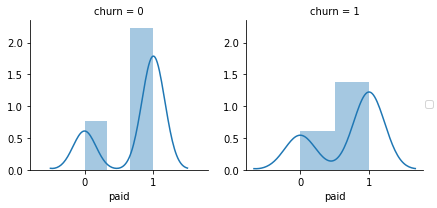

In [45]:
g = sns.FacetGrid(combined_agg_pd, palette="Set1",col="churn")
g.map(sns.distplot,'paid')
g.add_legend();

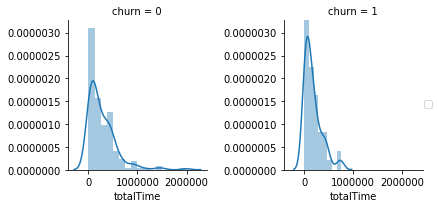

In [46]:
g = sns.FacetGrid(combined_agg_pd, palette="Set1",col="churn")
g.map(sns.distplot,'totalTime')
g.add_legend();

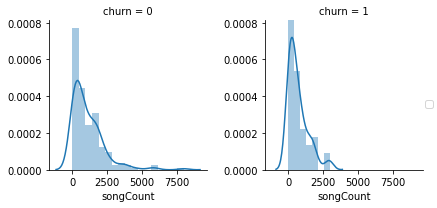

In [47]:
g = sns.FacetGrid(combined_agg_pd, palette="Set1",col="churn")
g.map(sns.distplot,'songCount')
g.add_legend();

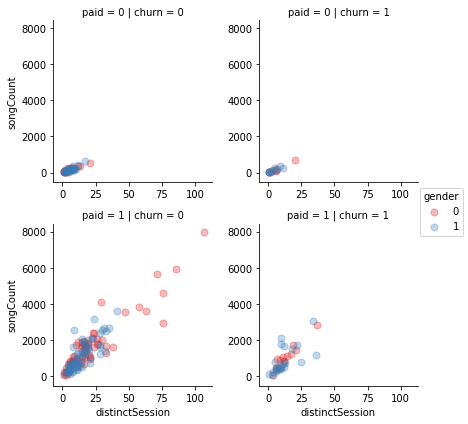

In [48]:
g = sns.FacetGrid(combined_agg_pd, palette="Set1",col="churn",row="paid",hue="gender")
g.map(plt.scatter,'distinctSession','songCount',s=50,alpha=0.3)
g.add_legend();

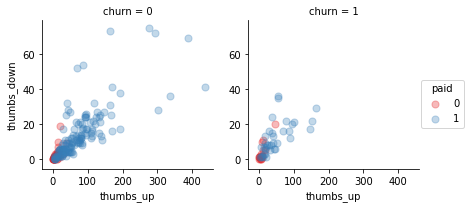

In [49]:
g = sns.FacetGrid(combined_agg_pd, palette="Set1",col="churn", hue='paid')
g.map(plt.scatter,'thumbs_up','thumbs_down',s=50,alpha=0.3)
g.add_legend();

From the above graphs we can observer the following: 
1. There are higher percentage of paid than non-paid Non-churned users
2. Non-churn users spend more time on the site, have more song counts and have more activities than those who churned

# Feature Engineering

In [50]:
numericCols = combined_agg_df.columns
numericCols.remove("churn")
numericCols.remove("userId")
numericCols.remove("userAgent")

In [51]:
print(numericCols)
stages = []

# Transform all features into a vector using VectorAssembler
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
standardscaler=StandardScaler().setInputCol("features").setOutputCol("scaledFeatures")
stages += [assembler,standardscaler]

['gender', 'distinctSession', 'songCount', 'totalTime', 'downgraded', 'upgraded', 'thumbs_up', 'thumbs_down', 'paid']


In [52]:
stages

[VectorAssembler_07ea80b132e2, StandardScaler_4d901f27409f]

In [53]:
#Run the stages as a Pipeline. 
#This puts the data through all of the feature transformations we described in a single call.
from pyspark.ml.classification import LogisticRegression  
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(combined_agg_df)
preppedDataDF = pipelineModel.transform(combined_agg_df)

In [54]:
preppedDataDF.select("features","scaledFeatures").show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[0.0,12.0,717.0,1...|[0.0,0.8192868504...|
|[0.0,17.0,1705.0,...|[0.0,1.1606563715...|
|[1.0,30.0,2577.0,...|[2.00127105192366...|
|[1.0,20.0,1409.0,...|[2.00127105192366...|
|[0.0,7.0,206.0,49...|[0.0,0.4779173294...|
+--------------------+--------------------+
only showing top 5 rows



In [55]:
preppedDataDF.printSchema()

root
 |-- userId: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- distinctSession: long (nullable = false)
 |-- songCount: long (nullable = false)
 |-- totalTime: double (nullable = true)
 |-- downgraded: long (nullable = true)
 |-- upgraded: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- churn: long (nullable = true)
 |-- paid: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [56]:
# Split dataset into training, test 
(training, test) = preppedDataDF.randomSplit([0.8, 0.2], seed=42)
print(training.count())
print(test.count())

179
46


In [58]:
# Try logistics Regression 
lr = LogisticRegression(labelCol="churn", featuresCol="scaledFeatures",maxIter=10)
model=lr.fit(training)
predict_train=model.transform(training)
predict_test=model.transform(test)

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [60]:
predict_test.select('prediction', 'churn').show(100)

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    1|
|       0.0|    0|
+----------+-----+



In [75]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn",metricName='f1')
f1_score = evaluator.evaluate(predict_test)
print("f1: {}".format(f1_score))

f1: 0.7171293871136721


In [70]:
AUC_PR=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="churn", metricName='areaUnderPR')
# areaUnderPR = Area under Precision-Recall => should be used when there is a moderate to large class imbalance.
predict_test.select("churn","rawPrediction","prediction","probability")
print("The area under PR for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under PR for test set is {}".format(evaluator.evaluate(predict_test)))

+-----+--------------------+----------+--------------------+
|churn|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[1.60399686438304...|       0.0|[0.83257626099389...|
|    1|[1.26943433233612...|       0.0|[0.78064589955859...|
|    0|[1.06470449173221...|       0.0|[0.74358855284140...|
|    0|[1.84109689976983...|       0.0|[0.86307838418544...|
|    1|[0.44011185184452...|       0.0|[0.60828568247929...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

The area under PR for train set is 0.3896190375987564
The area under PR for test set is 0.24708123324083958


In [72]:
# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder().build()


In [ ]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations

cvModel = cv.fit(training)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
pred = cvModel.transform(test)

#### Reference
- https://spark.apache.org/docs/latest/ml-classification-regression.html
- https://docs.databricks.com/applications/machine-learning/mllib/binary-classification-mllib-pipelines.html
- https://medium.com/@dhiraj.p.rai/logistic-regression-in-spark-ml-8a95b5f5434c
- https://databricks.com/session/apache-spark-mllib-2-0-preview-data-science-and-production